In [1]:
import numpy as np
from scipy.stats import beta
from scipy.special import kl_div
import matplotlib.pyplot as plt
import os, shutil
from copy import deepcopy, copy

In [2]:
def policy(q_values, temp=None, type='softmax'):

    '''
    ----
    Agent's policy
    q_values -- q values at the current state
    temp     -- inverse temperature
    type     -- softmax / greeedy
    ----
    '''

    if np.all(q_values == 0):
        return np.array([0.5, 0.5])

    if temp:
        t = temp
    else:
        t = 1
        
    if type == 'softmax':
        return np.exp(q_values*t)/np.sum(np.exp(q_values*t))
    else:
        return np.array(q_values >= q_values.max()).astype(int)

def belief_update(M_curr, arm, rew):

    '''
    ----
    Bayesian belief updates for beta prior
    M_curr -- matrix with the current beliefs
    arm    -- chosen arm 
    rew    -- received reward
    ----
    '''

    M_next = M_curr.copy()
    if rew == 1:
        M_next[arm, 0] += 1
    else:
        M_next[arm, 1] += 1
    return M_next

### Construct belief tree

In [3]:
def get_belief_tree(h, b):

    '''
    Generate planning belief tree
    ----
    h -- horizon
    b -- initial belief at the root
    Q -- MF Q values at the root 
    ----
    '''

    # initialise the hyperstate tree
    tree = {hi:{} for hi in range(h)}
    
    tree[0][(0, 0, 0)] = b

    for hi in range(1, h):
        c = 0
        if hi == 1:
            for a in range(2):
                for r in [1, 0]:
                    b1 = belief_update(b, a, r)
                    tree[hi][(a, 0, c)] = b1
                    c += 1
        else:
            for k, v in tree[hi-1].items():
                prev_c = k[-1]
                for a in range(2):
                    for r in [1, 0]:
                        b1 = belief_update(v, a, r)
                        tree[hi][(a, prev_c, c)] = b1
                        c += 1
    return tree

### Replay in belief tree

We want to prioritise updates in this belief tree. The prioritisation scheme is the following:

$$
\begin{align*}
    v(ba^*)-v(b) =& \mathbb{E}_{b'\sim p(b'\mid b, a^*)}\Big[\sum_a \big(\pi(a\mid b')-\pi(a\mid b)\big)q(b',a) \\
    +& \mathbb{E}_{a\sim \pi(a\mid b)}\big[r(b',a) - r(b,a)\big]  \\ 
    +& \mathbb{E}_{a\sim \pi(a\mid b)}\big[\gamma \sum_{b''}p(b''\mid b', a)v(b'') - \gamma \sum_{g'}p(g'\mid b, a)v(g') \big] \Big] 
\end{align*}
$$

where $ba^*$ is a belief that results from choosing action $a^*$ from belief $b$, the policy $\pi(a\mid b)$ is determined by the Gittins index associated with belief $b$, $q(b', a)$ is the Gittins index, and $v(b')=\mathbb{E}_{\pi(a\mid b')}\big[q(b',a)\big]$

For the moment, we will only consider single-step updates from children to their parents

In [52]:
def replay(tree, Q, xi=0.1):
    '''
    Perform replay updates in the belief tree
    ----
    tree -- belief tree
    Q    -- MF Q values at the root
    xi   -- EVB threshold
    ----
    '''

    h         = len(tree.keys())           # planning horizon
    evb_tree  = {hi:{} for hi in range(h)} # tree with evb values for each node
    qval_tree = {hi:{} for hi in range(h)} # tree with value estimate for each node
    need_tree = {hi:{} for hi in range(h)}
    backups   = [None]

    qval_history = []
    need_history = []

    for hi in range(h):
        for k, b in tree[hi].items():
            # Q values at the root
            if (hi == 0):
                q_values = Q
            # Q values at the leaves
            elif (hi == h-1):
                q_values = np.array([b[0, 0]/np.sum(b[0, :]), b[1, 0]/np.sum(b[1, :])]) # initial q-values are just the immediate rewards
            # intermediate Q values
            else:
                q_values = np.zeros(2)
                
            qval_tree[hi][k] = copy(q_values) # change temperature?

            prev_c = k[-2]
            c      = k[-1]
            a      = k[0]
            proba  = 1
            for hin in reversed(range(hi)):
                for kn, bn in tree[hin].items():
                    if kn[-1] == prev_c:
                        policy_proba = policy(qval_tree[hin][kn])
                        proba *= policy_proba[a]*(bn[a, c%2]/np.sum(bn[a, :]))

                        c      = kn[-1]
                        prev_c = kn[-2]
                        a      = kn[0]
                        break

            need_tree[hi][k] = proba

    qval_history += [deepcopy(qval_tree)]
    need_history += [deepcopy(need_tree)]

    # compute evb for every backup
    num = 0
    while True: # for N steps
        max_evb = 0

        nqval_tree = {hi:{} for hi in range(h)} # tree with new updated value estimates for each node
        for hi in reversed(range(h-1)):
            for k, b in tree[hi].items():
                
                q        = qval_tree[hi][k].copy()     # Q values of this belief state
                v        = np.dot(policy(q), q) # value of this belief state

                # -- probability of reaching this belief state -- #
                prev_c = k[-2]
                c      = k[-1]
                a      = k[0]
                proba  = 1
                for hin in reversed(range(hi)):
                    for kn, bn in tree[hin].items():
                        if kn[-1] == prev_c:
                            policy_proba = policy(qval_tree[hin][kn])
                            proba *= policy_proba[a]*(bn[a, c%2]/np.sum(bn[a, :]))

                            c      = kn[-1]
                            prev_c = kn[-2]
                            a      = kn[0]
                            break

                need_tree[hi][k] = proba
                        
                v_primes = []

                c = k[-1]
                for a in range(2):
                    v_primes = []
                    for k1, q1 in qval_tree[hi+1].items():
                        prev_c = k1[-2]
                        if prev_c == c and k1[0] == a:
                            v_primes += [np.dot(policy(q1), q1)] # values of next belief states

                    # new (updated) Q value for action a
                    q_upd = (b[a, 0]/np.sum(b[a, :]))*(1 + gamma*v_primes[0]) + (b[a, 1]/np.sum(b[a, :]))*(0 + gamma*v_primes[1])

                    if a == 0:
                        q_new = np.array([q_upd, q[1]])
                    else:
                        q_new = np.array([q[0], q_upd])
                    
                    v_new   = np.dot(policy(q_new), q_new) 

                    new_key = tuple(list(k) + [a])
                    
                    # can i get this proba here? it should be 
                    # different after each new replay update 
                    # (for the updated state, of course)

                    # proba = 0.5
                    evb   = proba*(v_new - v)
                    # evb = v_new - v
                        
                    if evb > max_evb:
                        max_evb = evb

                    evb_tree[hi][new_key]   = evb
                    nqval_tree[hi][new_key] = q_upd

        if max_evb < xi:
            break

        max_val = 0
        for hi in reversed(range(h-1)):
            for k, v in evb_tree[hi].items():
                if v > max_val:
                    backup  = [hi, k]
                    max_val = v
        if max_val <= 0:
            return qval_history, need_history, backups

        hi = backup[0]
        k  = backup[1][:-1]
        a  = backup[1][-1]

        qvals            = qval_tree[hi][k]
        qvals[a]         = nqval_tree[hi][backup[1]]
        qval_tree[hi][k] = qvals

        qval_history += [deepcopy(qval_tree)]
        need_history += [deepcopy(need_tree)]
        backups      += [[tree[hi][k], backup[0], backup[1]]]

        if num > 20:
            break
        num += 1

    return  qval_history, need_history, backups

### Initialise the agent

In [53]:
# M = np.array([
#     [100, 1],
#     [1, 100]
# ])

# gamma = 0.9

# Q = np.array([3, 1])

In [54]:
# from tex_tree import generate_tex_tree

# h    = 3
# tree = get_belief_tree(h, M)
# val_tree, replays = replay(tree, Q, xi=0.1)
# save_path = os.path.join('/home/georgy/Documents/Dayan_lab/PhD/bandits/Data/Tree/tex_tree_small.tex')
# generate_tex_tree(M, replays, save_path)

In [55]:
M = np.array([
    [10, 1],
    [5, 5]
])

gamma = 0.9

Q = np.array([2, 1])

In [56]:
from tex_tree import generate_big_tex_tree

h    = 4
tree = get_belief_tree(h, M)
qval_history, need_history, replays = replay(tree, Q, xi=0.3)

save_folder = '/home/georgy/Documents/Dayan_lab/PhD/bandits/Reports/2/data/Tree/seq/'
if os.path.exists(save_folder):
    shutil.rmtree(save_folder)
    os.mkdir(save_folder)
else:
    os.makedirs(save_folder)

for idx, rep in enumerate(replays):
    these_replays = replays[:idx+1]
    save_path = os.path.join(save_folder, 'tex_tree_%u.tex'%idx)
    generate_big_tex_tree(h, these_replays, qval_history[idx], need_history[idx], save_path)

In [57]:
need_history[1][1]

{(0, 0, 0): 6.645987078454589e-01,
 (0, 0, 1): 0.0664598707845459,
 (1, 0, 2): 0.13447071068499755,
 (1, 0, 3): 0.13447071068499755}

### Distribution updates asymmetry 

In [10]:
x = np.linspace(0.001, 1, 100)

a1b, b1b = np.array([2, 1])
rv1b = beta(a1b, b1b)  

a1a, b1a = np.array([3, 1])
rv1a = beta(a1a, b1a)

a1aa, b1aa = np.array([4, 1])
rv1aa = beta(a1aa, b1aa)

9.461856116669543
4.593524629783815


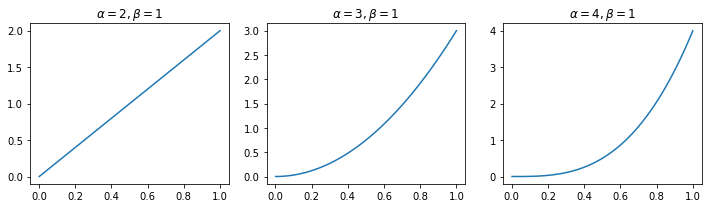

In [11]:
plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.plot(x, rv1b.pdf(x))
plt.title(r'$\alpha=2, \beta=1$')

plt.subplot(132)
plt.plot(x, rv1a.pdf(x))
plt.title(r'$\alpha=3, \beta=1$')

print(np.sum(kl_div(rv1b.pdf(x), rv1a.pdf(x))))

plt.subplot(133)
plt.plot(x, rv1aa.pdf(x))
plt.title(r'$\alpha=4, \beta=1$')

print(np.sum(kl_div(rv1a.pdf(x), rv1aa.pdf(x))))

plt.tight_layout()

# plt.savefig('/home/georgy/Documents/Dayan_lab/PhD/bandits/Data/betas.png')